In [ ]:
#The dataset for this notebook can be found here: https://www.kaggle.com/mohansacharya/graduate-admissions

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
raw_data = pd.read_csv("Admission Prediction Dataset.csv")
raw_data.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [3]:
raw_data.columns

Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit '],
      dtype='object')

In [4]:
#seeing the stats of the data
data_stats = raw_data.describe()
data_stats

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,250.500000,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,144.481833,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,125.750000,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,250.500000,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,375.250000,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,500.000000,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


In [5]:
#checking null values -> no null values in the data. Yay
raw_data.isnull().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

In [6]:
#finding variance inflation factor in data
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
vif_data = add_constant(raw_data[raw_data.columns[1: -1]])


In [7]:
pd.Series([variance_inflation_factor(vif_data.values, i) 
               for i in range(vif_data.shape[1])], 
              index=vif_data.columns)

const                1511.495830
GRE Score               4.464249
TOEFL Score             3.904213
University Rating       2.621036
SOP                     2.835210
LOR                     2.033555
CGPA                    4.777992
Research                1.494008
dtype: float64

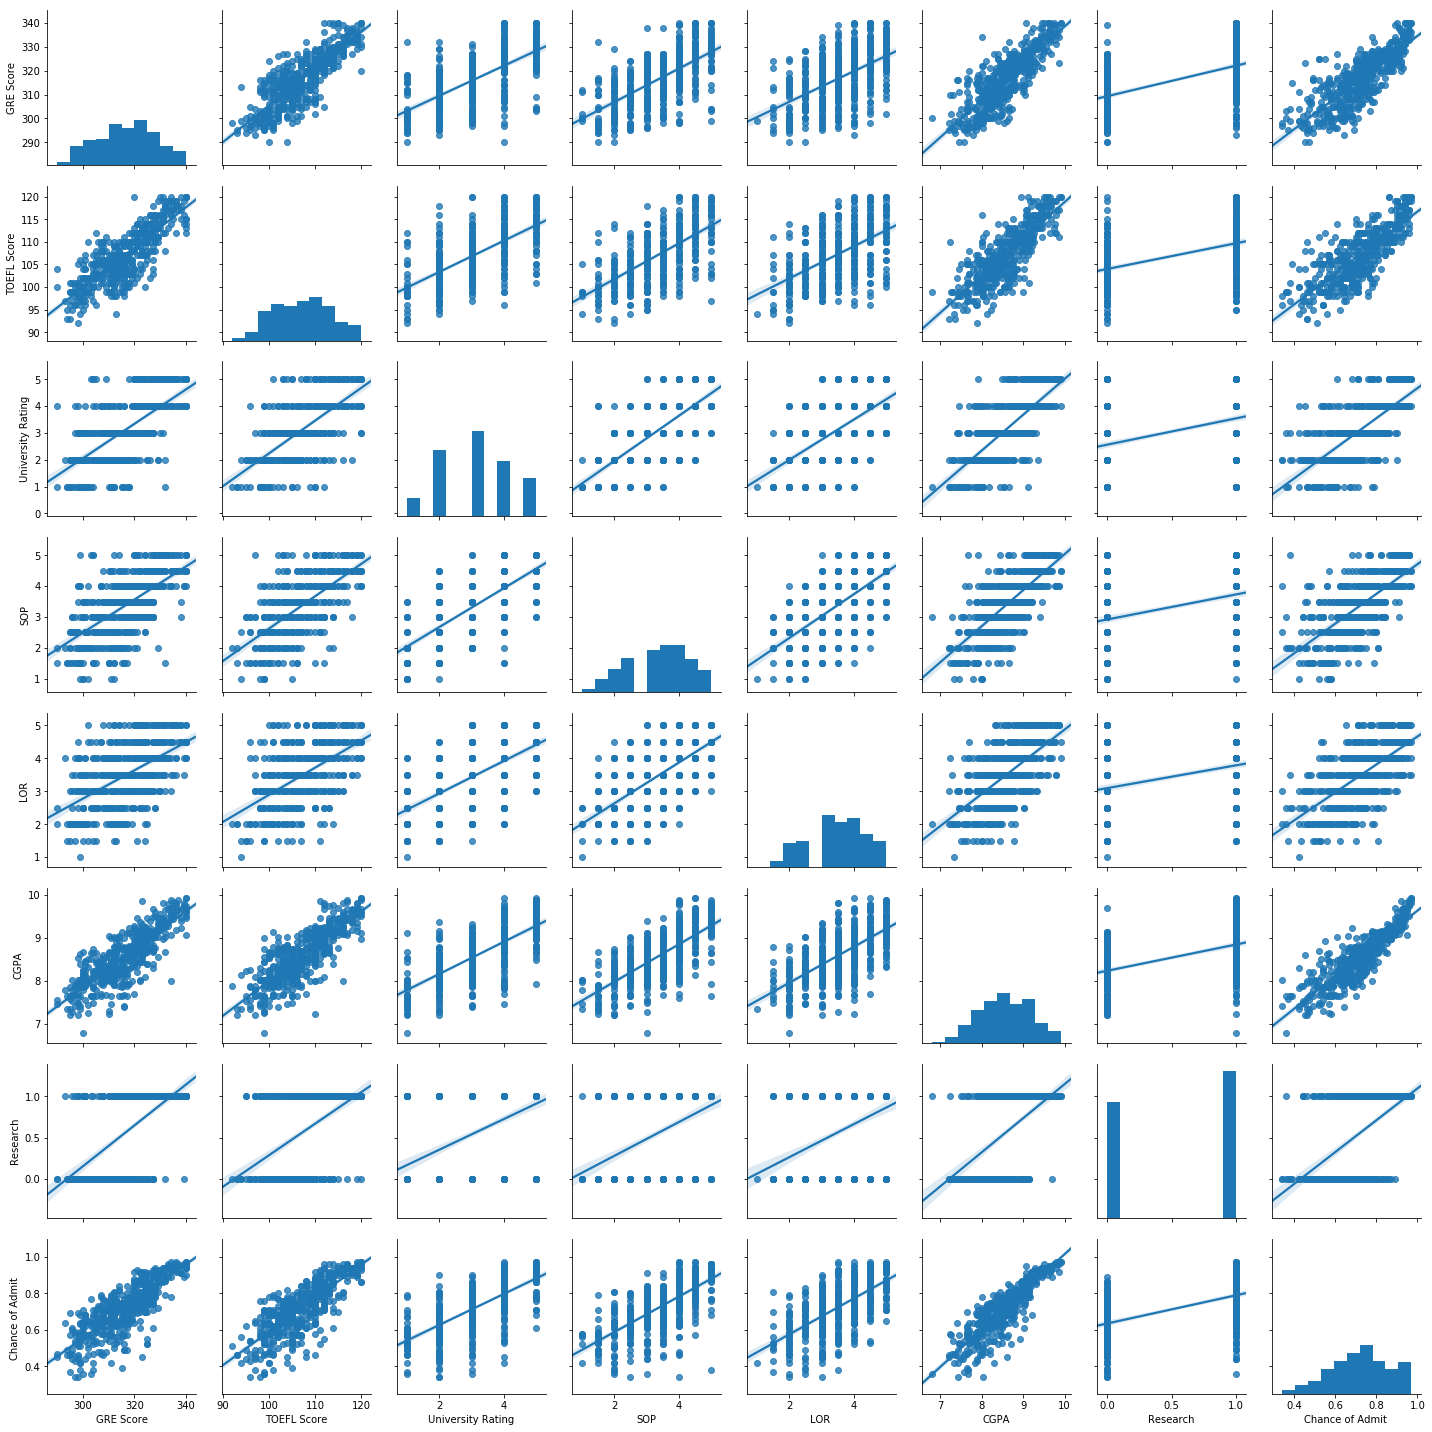

In [8]:
sns.pairplot(raw_data.loc[:,"GRE Score" : "Chance of Admit "], kind = "reg")
plt.show()

In [9]:
#seeing which features are most relevant
from sklearn.feature_selection import SelectKBest, chi2

In [10]:
feature_selection_data = raw_data.iloc[:,1:-1]
best_features = SelectKBest(k = "all")
best_features_scores = best_features.fit(feature_selection_data, raw_data.iloc[:,-1])

In [11]:
scores = pd.DataFrame(best_features_scores.scores_)
pVals = pd.DataFrame(best_features_scores.pvalues_)
best_feature_cols = pd.DataFrame(feature_selection_data.columns)
best_features_final = pd.concat([best_feature_cols, scores, pVals], axis = 1)
best_features_final.columns = ["Feature", "Score", "p-value"]

In [12]:
best_features_final.nlargest(6, "Score")

,Feature,Score,p-value
5,CGPA,33.666458,1.162218e-129
0,GRE Score,19.988947,2.147954e-92
1,TOEFL Score,18.493835,2.703098e-87
2,University Rating,10.170409,8.648083e-53
3,SOP,9.534057,1.338690e-49
4,LOR,7.062537,3.035948e-36


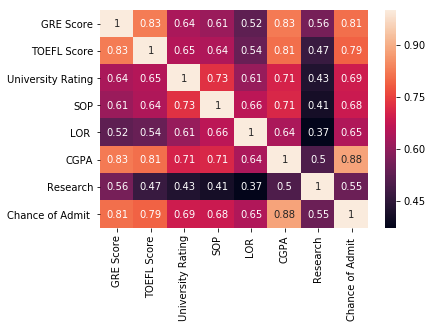

In [13]:
#heatmap showing the correlation between all variables:
sns.heatmap(raw_data.iloc[:,1:].corr(), annot = True)
plt.show()

In [14]:
def normalize(data):
    return (data - data_stats.loc["mean"]) / data_stats.loc["std"]
features = raw_data[['GRE Score', 'TOEFL Score', 'SOP', 'LOR ', 'CGPA', 'University Rating']]
norm_features = normalize(features)
norm_features.pop("Chance of Admit ")
norm_features.pop("Serial No.")
norm_features.pop("Research")
norm_features

,CGPA,GRE Score,LOR,SOP,TOEFL Score,University Rating
0,1.775029,1.817417,1.097845,1.136222,1.777086,0.774806
1,0.485373,0.666481,1.097845,0.631683,-0.031569,0.774806
2,-0.953088,-0.041788,0.017289,-0.377395,-0.524839,-0.099693
3,0.154692,0.489414,-1.063267,0.127144,0.461700,-0.099693
4,-0.605873,-0.218855,-0.522989,-1.386473,-0.689262,-0.974192
5,1.262473,1.197682,-0.522989,1.136222,1.283816,1.649305
6,-0.622407,0.400880,0.557567,-0.377395,0.297277,-0.099693
7,-1.118429,-0.750057,0.557567,-0.377395,-1.018108,-0.974192
8,-0.953088,-1.281258,-2.143823,-1.386473,-0.853685,-1.848691
9,0.038954,0.577947,-0.522989,0.127144,0.132854,-0.099693


In [15]:
targets = raw_data.iloc[:,-1]
lm = LinearRegression()
xTrain, xTest, yTrain, yTest = train_test_split(norm_features, targets, test_size = 0.2, random_state = 10)
lm.fit(xTrain, yTrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [16]:
lm.score(xTest, yTest)

0.7871856774622965

In [17]:
predictions = lm.predict(xTest)
np.sqrt(mean_squared_error(predictions, yTest))

0.06064707584274698

In [18]:
from xgboost import XGBRegressor

In [19]:
xgb_model = XGBRegressor(n_estimators = 500, learning_rate = 0.05)
xgb_model.fit(xTrain, yTrain,
             early_stopping_rounds = 5,
             eval_set = [(xTest, yTest)],
             verbose = False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.05, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=500, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

In [20]:
xgb_predictions = xgb_model.predict(xTest)
np.sqrt(mean_squared_error(xgb_predictions, yTest))

0.06724855706846755

In [21]:
xgb_model.score(xTest, yTest)

0.7383341408060217

In [22]:
from sklearn.ensemble import RandomForestRegressor

C:\Users\longn\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [23]:
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=1)
random_forest_model.fit(xTrain, yTrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [24]:
random_forest_model.score(xTest,yTest)

0.7666081158410674

In [25]:
random_forest_predictions = random_forest_model.predict(xTest)
np.sqrt(mean_squared_error(random_forest_predictions, yTest))

0.06351149187351839

In [66]:
def build_tf_model():
    model = keras.Sequential()
    model.add(keras.layers.Dense(64, activation = "relu", input_shape = [len(norm_features.keys())]))
    model.add(keras.layers.Dense(64, activation = "relu"))
    model.add(keras.layers.Dense(1))
    
    model.compile(loss = "mse", optimizer = keras.optimizers.Adam(learning_rate = 0.03), metrics = ["mse"])
    
    return model

In [67]:
tf_model = build_tf_model()

In [72]:
tf_model.fit(xTrain, yTrain, epochs=10,
    validation_split=0.2)

Epoch 1/10
10/10 [==============================] - 0s 9ms/step - loss: 0.1050 - mse: 0.1050 - val_loss: 0.0769 - val_mse: 0.0779
Epoch 2/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0463 - mse: 0.0463 - val_loss: 0.0305 - val_mse: 0.0305
Epoch 3/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0140 - mse: 0.0140 - val_loss: 0.0094 - val_mse: 0.0085
Epoch 4/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0091 - val_mse: 0.0077
Epoch 5/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0074 - val_mse: 0.0061
Epoch 6/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0076 - val_mse: 0.0067
Epoch 7/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0069 - val_mse: 0.0061
Epoch 8/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0043 - mse: 0

In [73]:
tf_predictions = tf_model.predict(xTest)
np.sqrt(mean_squared_error(tf_predictions, yTest))

0.06431962860625379

In [30]:
#all the above, using kfold cross validation and averaging out the rsme
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor

In [78]:
kfold = KFold(n_splits=5, shuffle = True, random_state = 10)
all_models = [
    ("Linear Regression", LinearRegression()),
    ("KNeighbors", KNeighborsRegressor()),
    ("XGBoost Regression", XGBRegressor(n_estimators = 500, learning_rate = 0.05)),
    ("Random Forest", RandomForestRegressor(n_estimators = 100, random_state = 10))]

In [80]:
for model_name, model_constructor in all_models:
    print(model_name + " RSME: ")
    rsme_vals = []
    for train_index, test_index in kfold.split(norm_features):
        current_model = model_constructor
        X_train, X_test = norm_features.iloc[train_index], norm_features.iloc[test_index]
        y_train, y_test = targets[train_index], targets[test_index]
        current_model.fit(X_train, y_train)
        predictions = current_model.predict(X_test)
        rsme_vals.append(np.sqrt(mean_squared_error(predictions, y_test)))
        
    print(rsme_vals)
    print("avg rsme: " + str(np.mean(rsme_vals)))
    print()

Linear Regression RSME: 
[0.060647075842746985, 0.06335933439762792, 0.05860282932223722, 0.06618643949769416, 0.05856126289311544]
avg rsme: 0.061471388390684334

KNeighbors RSME: 
[0.07168821381510351, 0.0722872049535739, 0.0650095377617777, 0.06746436096191827, 0.06945070194029719]
avg rsme: 0.06918000388653411

XGBoost Regression RSME: 
[0.07253868859112167, 0.07530948101460827, 0.07046373040676211, 0.07234917514604892, 0.06635922756570312]
avg rsme: 0.07140406054484882

Random Forest RSME: 
[0.0640145788082683, 0.0705687508745904, 0.06647091093102299, 0.06751080209862714, 0.06428866696393697]
avg rsme: 0.06657074193528915

